In [1]:
import numpy as np, torch
a = 5
np.random.seed(a)
torch.manual_seed(a)


In [ ]:
import os

DATA_ROOT = "data"  

GENRES = ["classical", "jazz"]

for g in GENRES:
    print(g, "→", len(os.listdir(os.path.join(DATA_ROOT, g))), "files")



classical → 100 files
jazz → 100 files


In [ ]:
import numpy as np
import librosa

import numpy as np
import librosa


SR = 22050       
DURATION = 30    
N_MFCC = 20      

def extract_features(file_path, n_mfcc=N_MFCC, sr=SR, duration=DURATION):
    """
    Load an audio file and return a 1D feature vector:
    [mean(mfcc_1..n), std(mfcc_1..n)] -> length 2 * n_mfcc
    """
    
    y, sr = librosa.load(file_path, sr=sr, duration=duration)

    
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)

    
    mfcc_mean = np.mean(mfcc, axis=1)
    mfcc_std = np.std(mfcc, axis=1)

    
    features = np.concatenate([mfcc_mean, mfcc_std], axis=0)
    return features


In [ ]:
X = []
y = []

for label_idx, genre in enumerate(GENRES):
    genre_folder = os.path.join(DATA_ROOT, genre)
    print(f"Processing genre: {genre} (label={label_idx})")

    for fname in os.listdir(genre_folder):
        if not fname.lower().endswith(".wav"):
            continue  # skip anything that isn't a wav file

        fpath = os.path.join(genre_folder, fname)
        try:
            feats = extract_features(fpath)
            X.append(feats)
            y.append(label_idx)
        except Exception as e:
            print(f"Error processing {fpath}: {e}")

X = np.array(X)
y = np.array(y)

print("Feature matrix shape:", X.shape)   
print("Labels shape:", y.shape)           
print("Class balance:", np.bincount(y))


Processing genre: classical (label=0)
Processing genre: jazz (label=1)


/var/folders/g6/sxpfrmcx633gsw66s9dyy5c80000gn/T/ipykernel_65898/185519134.py:18: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(file_path, sr=sr, duration=duration)
/Users/vedat/Desktop/CompPHYSFinalProject/.venv/lib/python3.13/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Error processing data/jazz/jazz.00054.wav: 
Feature matrix shape: (199, 40)
Labels shape: (199,)
Class balance: [100  99]


In [5]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt


In [6]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [7]:
clf = LogisticRegression(max_iter=2000)
clf.fit(X_train_scaled, y_train)

y_pred = clf.predict(X_test_scaled)

print("Classification report:")
print(classification_report(y_test, y_pred, target_names=["classical", "jazz"]))

cm = confusion_matrix(y_test, y_pred)
print("Confusion matrix:")
print(cm)


Classification report:
              precision    recall  f1-score   support

   classical       0.86      0.90      0.88        20
        jazz       0.89      0.85      0.87        20

    accuracy                           0.88        40
   macro avg       0.88      0.88      0.87        40
weighted avg       0.88      0.88      0.87        40

Confusion matrix:
[[18  2]
 [ 3 17]]


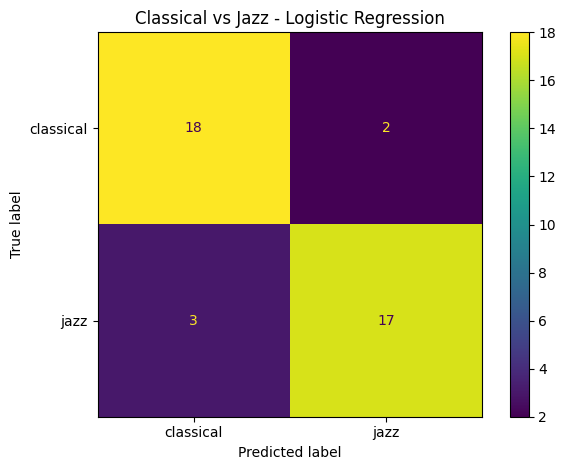

In [8]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["classical", "jazz"])
disp.plot(values_format='d')
plt.title("Classical vs Jazz - Logistic Regression")
plt.tight_layout()
plt.show()


In [9]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader



In [10]:
X_train_t = torch.tensor(X_train_scaled, dtype=torch.float32)
X_test_t  = torch.tensor(X_test_scaled,  dtype=torch.float32)
y_train_t = torch.tensor(y_train,        dtype=torch.float32).view(-1, 1)
y_test_t  = torch.tensor(y_test,         dtype=torch.float32).view(-1, 1)


In [11]:
model = nn.Sequential(
    nn.Linear(40, 64),
    nn.ReLU(),
    nn.Linear(64, 32),
    nn.ReLU(),
    nn.Linear(32, 1),
    nn.Sigmoid()
)

loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)


In [12]:
num_epochs = 40

for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    y_pred = model(X_train_t)
    loss = loss_fn(y_pred, y_train_t)
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}/{num_epochs}, Loss = {loss.item():.4f}")


Epoch 10/40, Loss = 0.6343
Epoch 20/40, Loss = 0.5489
Epoch 30/40, Loss = 0.4303
Epoch 40/40, Loss = 0.2996


MLP Classification report:
              precision    recall  f1-score   support

   classical       0.90      0.95      0.93        20
        jazz       0.95      0.90      0.92        20

    accuracy                           0.93        40
   macro avg       0.93      0.93      0.92        40
weighted avg       0.93      0.93      0.92        40



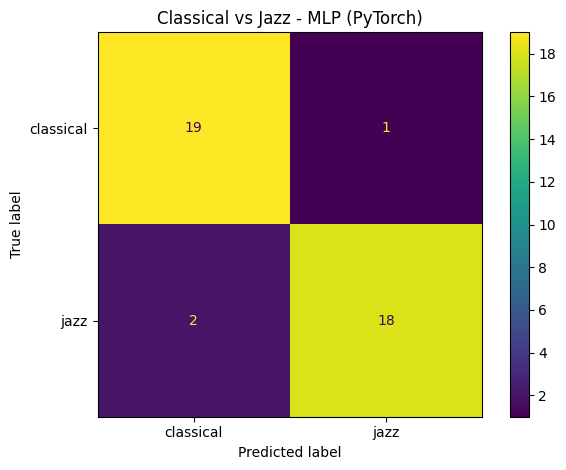

In [13]:
model.eval()
with torch.no_grad():
    y_proba = model(X_test_t)
    y_pred_mlp = (y_proba >= 0.5).int().numpy().flatten()

print("MLP Classification report:")
print(classification_report(y_test, y_pred_mlp, target_names=["classical", "jazz"]))

cm_mlp = confusion_matrix(y_test, y_pred_mlp)
disp = ConfusionMatrixDisplay(cm_mlp, display_labels=["classical", "jazz"])
disp.plot(values_format='d')
plt.title("Classical vs Jazz - MLP (PyTorch)")
plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
import librosa

def extract_dsp_features(file_path, sr=SR, duration=DURATION,
                         n_fft=2048, hop_length=512,
                         low_high_split=2000.0, roll_percent=0.85):
    """
    Classical DSP features derived from the Fourier power spectrum:
    - spectral centroid (Hz)
    - spectral rolloff frequency (Hz) containing `roll_percent` of energy
    - low/high energy ratio (below vs above `low_high_split` Hz)
    """
    y, sr = librosa.load(file_path, sr=sr, duration=duration)

    # STFT]
    S_complex = librosa.stft(y, n_fft=n_fft, hop_length=hop_length)
    # Power spectrogram 
    S_power = np.abs(S_complex)**2  # shape: (freq_bins, time_frames)

    # Frequency axis (Hz) corresponding to rows of S_power
    freqs = librosa.fft_frequencies(sr=sr, n_fft=n_fft)

    # Average over time 
    P = S_power.mean(axis=1)  
    
    # Avoid divide-by-zero
    if np.all(P == 0):
        return np.array([0.0, 0.0, 0.0], dtype=np.float32)

    # 1) Spectral centroid: 
    centroid = (freqs * P).sum() / P.sum()

    # 2) Spectral rolloff: 
    cumulative = np.cumsum(P)
    total_energy = cumulative[-1]
    threshold = roll_percent * total_energy
    idx_roll = np.searchsorted(cumulative, threshold)
    if idx_roll >= len(freqs):
        idx_roll = len(freqs) - 1
    rolloff_freq = freqs[idx_roll]

    # 3) Low/high energy ratio
    low_mask = freqs < low_high_split
    high_mask = ~low_mask
    energy_low = P[low_mask].sum()
    energy_high = P[high_mask].sum()
    energy_ratio = energy_low / (energy_high + 1e-10)

    return np.array([centroid, rolloff_freq, energy_ratio], dtype=np.float32)


In [ ]:
X_dsp = []
y_dsp = []

for label_idx, genre in enumerate(GENRES):
    genre_folder = os.path.join(DATA_ROOT, genre)
    print(f"Processing DSP features for genre: {genre} (label={label_idx})")

    for fname in os.listdir(genre_folder):
        if not fname.lower().endswith(".wav"):
            continue
        fpath = os.path.join(genre_folder, fname)
        try:
            feats = extract_dsp_features(fpath)
            X_dsp.append(feats)
            y_dsp.append(label_idx)
        except Exception as e:
            print(f"DSP error processing {fpath}: {e}")

X_dsp = np.array(X_dsp)
y_dsp = np.array(y_dsp)

print("DSP feature matrix shape:", X_dsp.shape) 
print("DSP labels shape:", y_dsp.shape)
print("DSP class balance:", np.bincount(y_dsp))


Processing DSP features for genre: classical (label=0)
Processing DSP features for genre: jazz (label=1)


/var/folders/g6/sxpfrmcx633gsw66s9dyy5c80000gn/T/ipykernel_65898/3081146844.py:13: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(file_path, sr=sr, duration=duration)
/Users/vedat/Desktop/CompPHYSFinalProject/.venv/lib/python3.13/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


DSP error processing data/jazz/jazz.00054.wav: 
DSP feature matrix shape: (199, 3)
DSP labels shape: (199,)
DSP class balance: [100  99]


DSP + Logistic Classification report:
              precision    recall  f1-score   support

   classical       0.56      0.75      0.64        20
        jazz       0.62      0.40      0.48        20

    accuracy                           0.57        40
   macro avg       0.59      0.57      0.56        40
weighted avg       0.59      0.57      0.56        40

DSP Confusion matrix:
[[15  5]
 [12  8]]


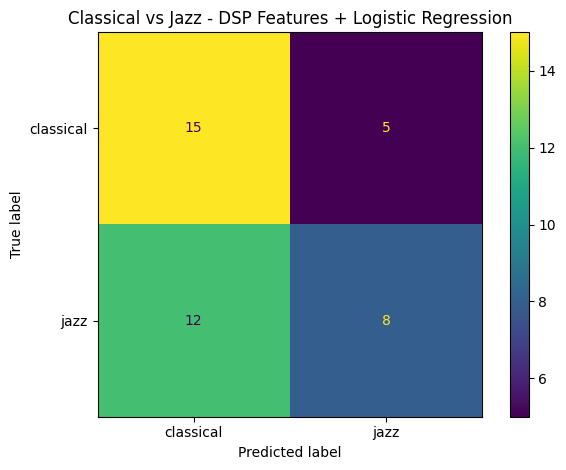

In [16]:
X_dsp_train, X_dsp_test, y_dsp_train, y_dsp_test = train_test_split(
    X_dsp, y_dsp, test_size=0.2, random_state=42, stratify=y_dsp
)

scaler_dsp = StandardScaler()
X_dsp_train_scaled = scaler_dsp.fit_transform(X_dsp_train)
X_dsp_test_scaled  = scaler_dsp.transform(X_dsp_test)

clf_dsp = LogisticRegression(max_iter=1000)
clf_dsp.fit(X_dsp_train_scaled, y_dsp_train)

y_dsp_pred = clf_dsp.predict(X_dsp_test_scaled)

print("DSP + Logistic Classification report:")
print(classification_report(y_dsp_test, y_dsp_pred, target_names=["classical", "jazz"]))

cm_dsp = confusion_matrix(y_dsp_test, y_dsp_pred)
print("DSP Confusion matrix:")
print(cm_dsp)

disp_dsp = ConfusionMatrixDisplay(confusion_matrix=cm_dsp, display_labels=["classical", "jazz"])
disp_dsp.plot(values_format='d')
plt.title("Classical vs Jazz - DSP Features + Logistic Regression")
plt.tight_layout()
plt.show()


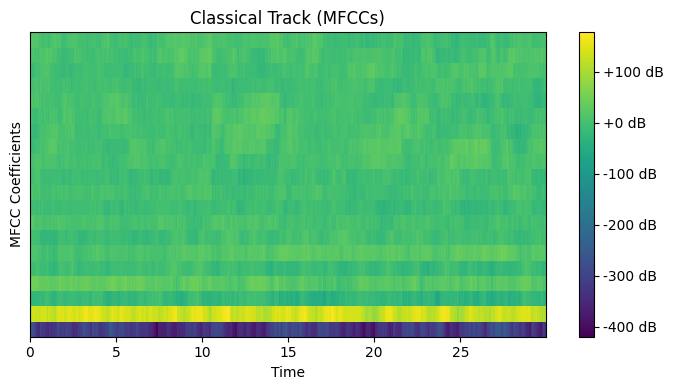

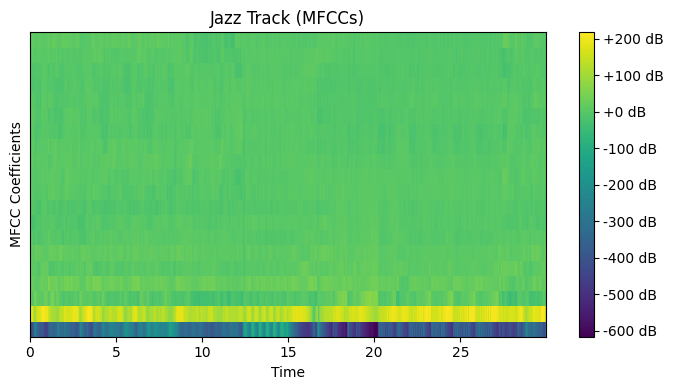

In [ ]:

import matplotlib.pyplot as plt


def plot_mfcc(file_path, title, sr=SR, n_mfcc=20):
    y, sr = librosa.load(file_path, sr=sr, duration=DURATION)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
    
    plt.figure(figsize=(7,4))
    librosa.display.specshow(mfcc, x_axis='time', sr=sr, cmap='viridis')
    plt.colorbar(format='%+2.0f dB')
    plt.title(title + " (MFCCs)")
    plt.xlabel("Time")
    plt.ylabel("MFCC Coefficients")
    plt.tight_layout()
    plt.show()

# Example usage:
CLASSICAL_FILE = os.path.join(DATA_ROOT, "classical", "classical.00001.wav")
JAZZ_FILE      = os.path.join(DATA_ROOT, "jazz", "jazz.00001.wav")

plot_mfcc(CLASSICAL_FILE, "Classical Track")
plot_mfcc(JAZZ_FILE, "Jazz Track")
